# Data preprocessing
The first main part of our project is to understand the data and the preprocessing done by the tile2vec model.

## Our dataset
The dataset provided to us is available [on kaggle](https://www.kaggle.com/datasets/apollo2506/eurosat-dataset/data). The data contains RGB and multispectral images collected by Sentinel-2 satellite within the EuroSAT project.

More about the data may be found [in the publication](https://arxiv.org/pdf/1709.00029.pdf).


| Band       | Spatial Resolution (m) | Central Wavelength (nm) |
|------------|------------------------|-------------------------|
| B01 - Aerosols | 60                   | 443                     |
| B02 - Blue  | 10                     | 490                     |
| B03 - Green | 10                     | 560                     |
| B04 - Red   | 10                     | 665                     |
| B05 - Red edge 1 | 20                | 705                     |
| B06 - Red edge 2 | 20                | 740                     |
| B07 - Red edge 3 | 20                | 783                     |
| B08 - NIR   | 10                     | 842                     |
| B08A - Red edge 4 | 20               | 865                     |
| B09 - Water vapor | 60               | 945                     |
| B10 - Cirrus | 60                     | 1375                    |
| B11 - SWIR 1 | 20                     | 1610                    |
| B12 - SWIR 2 | 20                     | 2190                    |

The data contains 27000 **labeled** images with 10 different land use and land cover cases from all over the Europe. Multispectral variant of images consists of 13 different bands. The images were collected from satellite from low-cloud level to avoid applying many cloud masks.
The proposed dataset has not received atmospheric correction. This can result in images with a color cast. 


### EuroSAT preprocessing
Before release the dataset was preprocessed. Firstly each band was resampled to 10m resoltion.  Bands with a lower spatial resolution have been upsampled to 10 meters per pixel using cubic-spline interpolation. (A practical guide to splines, volume 27. Springer-Verlag New York, 1978)

Then multiple Sentinel images were merged to create a larger image.
All of the images were manually inspected and classified. 


Ihe article proposed also a simple CNN with classification accuracy of 98.57%. The authors also compared performance of models that used only 1 band. It turned out that models that used any of RGB bands were performing better than the others. Even though band combinations outperforms the single-band images.
The non-RGB bands might be much more usefull than authors predicted, since the model they used to evaluate importance of bands was pretrained on RGB only images.

#### Side note on multispectral images
I think that the unit of the optical bands that we use is the reflectances - the ratio of reflected light by the surface. Thus this measure is simply percentage - how much light is reflected compared to the amount of light that could have been reflected.
Here is a textbook about mutlispectral data:
https://gistbok.ucgis.org/bok-topics/nature-multispectral-image-data

and some deeper dive into the sentinel bands:

https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/

General conclusion coming from the document above is that all the pixels we have are in the *DN* unit which is a abreviation of Digital Number and is an aproximation of reflectance. The *DN* values should be within the interval 0-4000, but, especially for infrared bands, they may exceed this value

### Dataset exploration

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.append('../')

In [4]:
df = pd.read_csv("/storage/EuroSATallBands/train.csv")
df.head()

,Filename,Label,ClassName
0,PermanentCrop/PermanentCrop_2401.tif,6,PermanentCrop
1,PermanentCrop/PermanentCrop_1006.tif,6,PermanentCrop
2,HerbaceousVegetation/HerbaceousVegetation_1025...,2,HerbaceousVegetation
3,SeaLake/SeaLake_1439.tif,9,SeaLake
4,River/River_1052.tif,8,River


## Band analysis

## Analysis of image based on a single one

In [5]:
from osgeo import gdal


sample_filepath = '/storage/EuroSATallBands/River/River_2115.tif'

val_type = "float32"
obj = gdal.Open(sample_filepath)
if val_type == 'uint8':
    img = obj.ReadAsArray().astype(np.uint8)
elif val_type == 'float32':
    img = obj.ReadAsArray().astype(np.float32)
else:
    raise ValueError('Invalid val_type for image values. Try uint8 or float32.')
img = np.moveaxis(img, 0, -1)

In [6]:
print("max values for each band:\n", img.max(axis=(0,1)))
print("min values for each band:\n", img.min(axis=(0,1)))

max values for each band:
 [1404. 1251. 1192. 1161. 1351. 4255. 5654. 5439.  869.   13. 2492. 1320.
 6078.]
min values for each band:
 [1256.  839.  566.  338.  357.  472.  512.  427.  225.    7.  179.   76.
  490.]


In [27]:
for band in range(1, obj.RasterCount):
    print(obj.GetRasterBand(band).GetMetadata()) # unfortunately the images do not contain any usefull metadata

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


In [9]:
print("Image shape: ", img.shape)
print("Image type: ", type(img))

Image shape:  (64, 64, 13)
Image type:  <class 'numpy.ndarray'>


### rasterio playground
below I do some quick evaluation of `rasterio` library that can read '.tif' files. It looks like better alternative to `gdal`

In [7]:
import rasterio
from rasterio.plot import show
dataset = rasterio.open(sample_filepath)
print(dataset.count)
print(dataset.height, dataset.width)

print(dataset.crs) # the dataset coordinate reference system
dataset

13
64 64
EPSG:32632


<open DatasetReader name='/storage/EuroSATallBands/River/River_2115.tif' mode='r'>

In [8]:
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}

{1: 'uint16',
 2: 'uint16',
 3: 'uint16',
 4: 'uint16',
 5: 'uint16',
 6: 'uint16',
 7: 'uint16',
 8: 'uint16',
 9: 'uint16',
 10: 'uint16',
 11: 'uint16',
 12: 'uint16',
 13: 'uint16'}

In [9]:
dataset.bounds # we have also some bounding boxes measured in meters (?)

BoundingBox(left=520237.6696400407, bottom=6014098.553057862, right=520877.21970925, top=6014737.626973448)

In [47]:
dataset.transform

Affine(9.992969831395342, 0.0, 520237.6696400407,
       0.0, -9.985529931034122, 6014737.626973448)

In [48]:
band1 = dataset.read(1) # bands are indexed from 1 

In [49]:
for band_number in range(dataset.count):
    print(f"{band_number}:", dataset.tags(band_number))

0: {'AREA_OR_POINT': 'Area'}
1: {}
2: {}
3: {}
4: {}
5: {}
6: {}
7: {}
8: {}
9: {}
10: {}
11: {}
12: {}


In [50]:
img = dataset.read()
img = np.moveaxis(img, 0, -1)

img_rgb = img.astype("float64")
tile = img_rgb

tile = (tile - np.min(tile, axis = (0,1)))/ np.max(tile, axis = (0,1)) # TODO better normalization
tile.shape

(64, 64, 13)

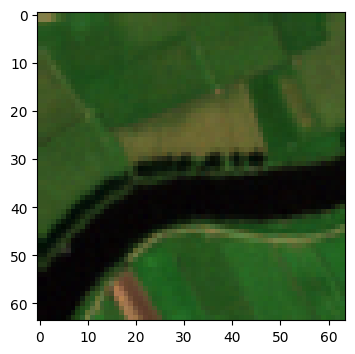

In [51]:
plt.rcParams['figure.figsize'] = (12,4)

plt.imshow(tile[:, :, [3,2,1]])

## band normalization
I want to check how the bands could be normalized - is using some apriori knowledge about bands beneficial?

In [59]:
from pathlib import Path
from tqdm import tqdm
df = pd.read_csv("/storage/EuroSATallBands/train.csv")
maxes = np.zeros((len(df), 13))
mins = np.zeros((len(df), 13))

for idx, filename in enumerate(tqdm(df["Filename"])):
    filename = Path("/storage/EuroSATallBands/") / filename
    dataset = rasterio.open(filename)
    img = dataset.read()
    maxes[idx, ] = np.max(img, axis=(1,2))
    mins[idx, ] = np.min(img, axis=(1,2))
    dataset.close()

  0%|          | 22/19317 [00:00<01:31, 211.10it/s]

100%|██████████| 19317/19317 [00:55<00:00, 350.86it/s]


(19317, 13)

In [64]:
maxes_df = pd.DataFrame(maxes)
mins_df = pd.DataFrame(mins)

Text(0.5, 0, 'band number')

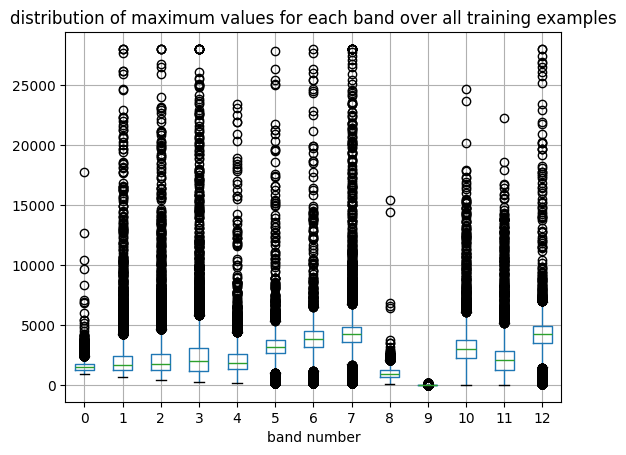

In [70]:
maxes_df.boxplot()
plt.title("distribution of maximum values for each band over all training examples")
plt.xlabel("band number")

Text(0.5, 0, 'band number')

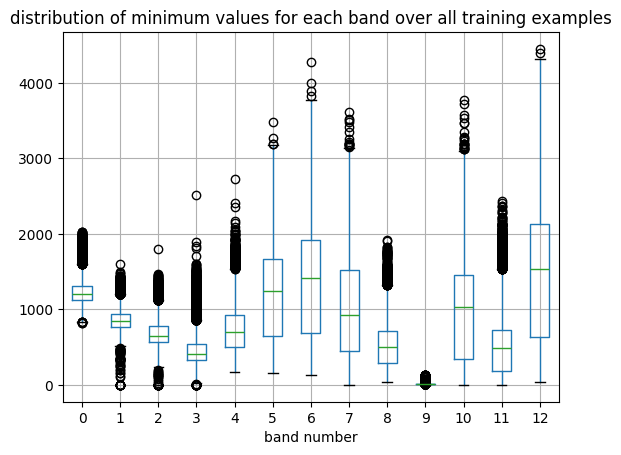

In [71]:
mins_df.boxplot()
plt.title("distribution of minimum values for each band over all training examples")
plt.xlabel("band number")

It turns out that when it comes to the normalization of bands this isn't that easy process that I expected. There are many outlier values of the DN units. The approach proposed by `tile2vec` data preprocessing may be enough, they are clipping the image to be in a certain predefined interval (that should not contain outliers, in implementation it is (0,10000)) and later scaling it to (0,1).

Maybe there should be a better normalization conducted - in case the clipping is exact for each band, bands such as B09 get very small values.

#

In [73]:
clip_min = 0
clip_max = 10000
tile2vec_img = np.clip(img, clip_min, clip_max) / (clip_max - clip_min)

In [94]:
bands = [tile2vec_img[:, :, i].flatten() for i in range(tile2vec_img.shape[2]) ]


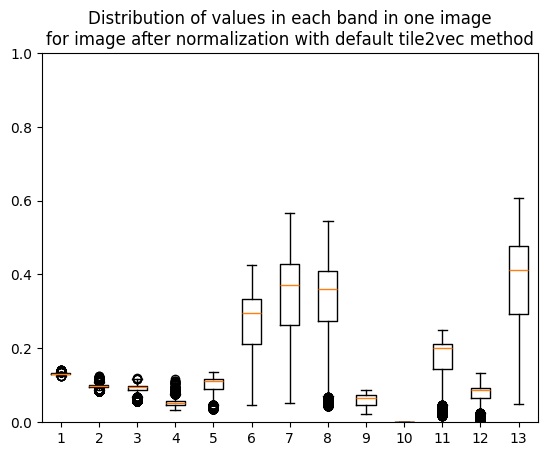

In [97]:
plt.boxplot(bands)
plt.title("Distribution of values in each band in one image\nfor image after normalization with default tile2vec method")
plt.ylim([0, 1])
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fade0dc1be0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fade0cd35f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fade0b73e60>],
 'medians': [<matplotlib.lines.Line2D at 0x7fade0c01550>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fade0b9c230>],
 'means': []}

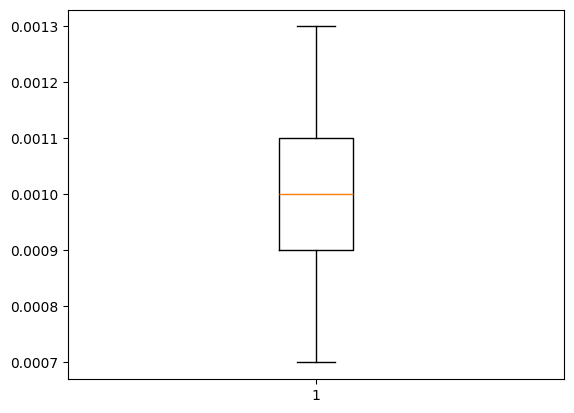

In [99]:
plt.boxplot(bands[9])

In [ ]:
# code for cliping
def clip_and_scale_image(img, img_type='naip', clip_min=0, clip_max=10000):
    """
    Clips and scales bands to between [0, 1] for NAIP, RGB, and Landsat
    satellite images. Clipping applies for Landsat only.
    """
    if img_type in ['naip', 'rgb']:
        return img / 255
    elif img_type == 'landsat':
        return np.clip(img, clip_min, clip_max) / (clip_max - clip_min)

## Spacing

Our dataset contains images of sampling 10 m and image size 64x64. Thus the *real* image size is 640m x 640m. It can be also seen from the tif metadata

In [59]:
bounds = dataset.bounds
print("Real width of image: ", - bounds.left + bounds.right)
print("Real height of image: ", bounds.top - bounds.bottom)

Real width of image:  639.5500692093046
Real height of image:  639.0739155858755


when it comes to tile2vec model, the sampling size is different for each dataset, we should not worry about the tile size nor sampling. However, the NAIP sampling distance is only 0.6m, which may affect the model performance.

I think we are ready to perform training using the code from tile2vec authors.